In [1]:
#===========================================================================================
# ALBERT Futher-PreTraining 예시
# => MLM(Masked Language Model) 과 SOP(Sentence Order Prediction) 로 Further Pre-Train 시키는 예시
# => AlbertForPreTraining 사용
# => next_sentence_label 대신에 sentence_order_label 이용
#
# 참고 자료 : https://huggingface.co/docs/transformers/model_doc/albert
#===========================================================================================

import torch
from transformers import AlbertTokenizer, AlbertForPreTraining
from tqdm.notebook import tqdm
from transformers import AdamW, get_linear_schedule_with_warmup
from os import sys
sys.path.append('..')
from myutils import GPU_info, seed_everything, mlogging, AccuracyForMaskedToken, SaveBERTModel

device = GPU_info()
print(device)

#seed 설정
seed_everything(222)

#logging 설정
logger =  mlogging(loggername="Albertfpt", logfilename="../../log/Albertfpt")


logfilepath:../../log/bwdataset_2022-06-08.log
logfilepath:../../log/qnadataset_2022-06-08.log
True
device: cuda:0
cuda index: 0
gpu 개수: 1
graphic name: NVIDIA A30
cuda:0
logfilepath:../../log/Albertfpt_2022-06-08.log


In [2]:
# 모델 불러옴 
vocab_path = '../../data11/model/albert/albert-base-v2-ftp-2' 
model_path = '../../data11/model/albert/albert-base-v2-ftp-2' 

tokenizer = AlbertTokenizer.from_pretrained(vocab_path)
print(len(tokenizer))

model = AlbertForPreTraining.from_pretrained(model_path)

# resize_token_embeddings 으로 신규 tokenizer 사이즈로 지정 해줌.
model.resize_token_embeddings(len(tokenizer))
model.to(device)

54152


Some weights of AlbertForPreTraining were not initialized from the model checkpoint at ../../data11/model/albert/albert-base-v2-ftp-2 and are newly initialized: ['albert.pooler.bias', 'sop_classifier.classifier.weight', 'albert.pooler.weight', 'sop_classifier.classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


AlbertForPreTraining(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(54152, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)

In [4]:
model.num_parameters()

14929418

In [5]:
# text tokenizer 해봄.
text = "모코엠시스에서는 문서중앙화 및 보안파일서버 솔루션인 엠파워를 출시하였다."
token_ids = tokenizer.encode_plus(text, max_length=128, padding="max_length", return_tensors="pt")
print(token_ids)

{'input_ids': tensor([[    2, 54150,     1, 54146, 30010, 54147, 30219,     1, 54148,     1,
         31858,     1,     9,     3,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,  

In [5]:
# 각 스페셜 tokenid를 구함
CLStokenid = tokenizer.convert_tokens_to_ids('[CLS]')
SEPtokenid = tokenizer.convert_tokens_to_ids('[SEP]')
UNKtokenid = tokenizer.convert_tokens_to_ids('<UNK>')
PADtokenid = tokenizer.convert_tokens_to_ids('<pad>')
MASKtokenid = tokenizer.convert_tokens_to_ids('[MASK]')

print(CLStokenid)
print(SEPtokenid)
print(UNKtokenid)
print(PADtokenid)
print(MASKtokenid)


2
3
1
0
4


In [ ]:
# test Data 불러옴.
# test data는 .으로 구분된 한줄 문자이 아니라. 한줄에 .로구분된 여러문장이 이어진 문장이어야 함
# 예시:'제임스 얼 "지미" 카터 주니어는 민주당 출신 미국 39번째 대통령 이다.지미 카터는 조지아주 섬터 카운티 플레인스 마을에서 태어났다.
input_corpus = '../../data/my_data/data.txt'

with open(input_corpus, 'r') as fp:
    text = fp.read().split('\n')
    
print(text[:2])

In [7]:
# SOP 만들기 위해, .을 기준으로 문장들을 나눈 후 길이를 얻어 둔다.
bag = [item for sentence in text for item in sentence.split('.') if item != '']
bag_size = len(bag)
print(bag_size)
print(bag[14])

24171
 1979년 백악관에서 양국 간의 평화조약으로 이끌어졌다


In [11]:
#=================================================================================================
# SOP 문장 만들기 
#
# => SOP는 주어진 한 쌍의 문장이 positive인지 negative인지 분류하는 이진 분류 문제이다.
# 문장 1: 그는 김치볶음밥을 요리했다.
# 문장 2: 맛있었다.
# =>주어진 한 쌍의 문장을 보면, 문장 2가 문장 1 다음에 온다는 것을 알 수 있다. 이때를 positive(0)라고 한다.

# 문장 1: 맛있었다.
# 문장 2: 그는 김치볶음밥을 요리했다.
# =>위 경우는 문장 순서가 바뀐 경우 이고 negetive(1)이다.
#=================================================================================================
import random

sentence_a = []
sentence_b = []
label = []

for paragraph in text:
    # 하나의 문장을 읽어와서 .기준으로 나눈다.
    sentences = [sentence for sentence in paragraph.split('.') if sentence != '']
    num_sentences = len(sentences)
    
     # . 기준으로 나눈 문장이 1이상이면..
    if num_sentences > 1:
        # 문장 a 시작번지는 랜덤하게, 해당 문장 이후로 지정
        start = random.randint(0, num_sentences-2)
        # 50/50 whether is IsNextSentence or NotNextSentence
        # 0.5 이상 랜덤값이면, 연속적인 문장으로 만듬
        if random.random() >= 0.5:
            # this is IsNextSentence
            sentence_a.append(sentences[start])
            sentence_b.append(sentences[start+1])
            label.append(0)  #label=0이면 연속적
        # 0.5 이하 랜덤값이면  순서를 바꿈
        else:
            # this is NotNextSentence
            sentence_a.append(sentences[start+1])
            sentence_b.append(sentences[start])
            label.append(1)  #label=1이면 순서가 바뀜

In [16]:
# label = 0 이면, 연속적인 문장, 1이면 순서가 바뀐 문장
for i in range(5):
    print(label[i])
    print(sentence_a[i] + '\n---')
    print(sentence_b[i] + '\n')

0
 Carter Begin, Camp David 1978
---
gif|섬네일|300px|캠프데이비드에서 사다트와 베긴과 함께카터는 이집트와 이스라엘을 조정하여, 캠프 데이비드에서 안와르 사다트 대통령과 메나헴 베긴 수상과 함께 중동 평화를 위한 캠프데이비드 협정을 체결했다

0
 벡터의 연구에는 산술, 대수, 기하라는 수학의 중요한 세개의 분야가 조합되어 있다
---
 벡터 미적분학은 여기에 해석학의 영역이 추가된다

1
13198 82487 943 비슈바나트 상수(Viswanath s constant 1 ) 수론 ? ? 13 L ≈0
---
76422 36535 89220 66 란다우-라마누잔 상수 수론 무리수 ( ? ) ? 30,010 K ≈ 1

0
 문예학은 음악사학, 미술사학 등과 함께 예술학의 핵심분야로서 인문학의 하위범주에 포함된다
---
 일반적으로 문학의 정의는 텍스트들의 집합이다

0
 스위스는 주로 나뉜 연합 국가이다
---
 ---- – 스페인 왕국 스페인어 España – Reino de España 유엔과 유럽 연합 가입 국가로 승인 받았다



In [18]:
# 위 SOP 리스트 들을 tokenizer 함
token_max_len = 256
# max_length = 512 하면 GPU Memory 오류 발생함
inputs = tokenizer(sentence_a, sentence_b, return_tensors='pt',
                   max_length=token_max_len, truncation=True, padding='max_length')

print(inputs.keys())

print(inputs)

Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.


dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
{'input_ids': tensor([[    2,  4323,  2348,  ...,     0,     0,     0],
        [    2, 35480,     1,  ...,     0,     0,     0],
        [    2, 36799,  3804,  ...,     0,     0,     0],
        ...,
        [    2, 30001,     1,  ...,     0,     0,     0],
        [    2, 31660, 30566,  ...,     0,     0,     0],
        [    2, 33093,     1,  ...,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}


In [21]:
# tokenizer 한 SOP 에 'sentence_order_label' 값(0,1) 추가함
inputs['sentence_order_label'] = torch.LongTensor([label]).T

print(inputs.sentence_order_label[:10])

tensor([[0],
        [0],
        [1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [1],
        [0]])


In [22]:
# MLM 만들기

# labels에는 inputs_id를 복사해서 추가
inputs['labels'] = inputs.input_ids.detach().clone()

print(inputs.keys())

dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'sentence_order_label', 'labels'])


In [23]:
# 각 스페셜 tokenid를 구함
CLStokenid = tokenizer.convert_tokens_to_ids('[CLS]')
SEPtokenid = tokenizer.convert_tokens_to_ids('[SEP]')
UNKtokenid = tokenizer.convert_tokens_to_ids('<UNK>')
PADtokenid = tokenizer.convert_tokens_to_ids('<pad>')
MASKtokenid = tokenizer.convert_tokens_to_ids('[MASK]')
print('CLSid:{}, SEPid:{}, UNKid:{}, PADid:{}, MASKid:{}'.format(CLStokenid, SEPtokenid, UNKtokenid, PADtokenid, MASKtokenid))

# create random array of floats with equal dimensions to input_ids tensor
rand = torch.rand(inputs.input_ids.shape)
# create mask array
mask_arr = (rand < 0.15) * (inputs.input_ids != 101) * \
           (inputs.input_ids != CLStokenid) * (inputs.input_ids != SEPtokenid) * \
           (inputs.input_ids != UNKtokenid) * (inputs.input_ids != PADtokenid) * \
           (inputs.input_ids != MASKtokenid)

selection = []
for i in range(inputs.input_ids.shape[0]):
    selection.append(
        torch.flatten(mask_arr[i].nonzero()).tolist()
    )
    
print(selection[:2])

# inputs_ids 에 [MASK] 추가시킴
for i in range(inputs.input_ids.shape[0]):
    inputs.input_ids[i, selection[i]] = MASKtokenid
    

print(inputs.keys())
print(inputs.input_ids)

CLSid:2, SEPid:3, UNKid:1, PADid:0, MASKid:4
[[5, 6, 25, 27, 33], [5, 19, 25, 27]]
dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'sentence_order_label', 'labels'])
tensor([[    2,  4323,  2348,  ...,     0,     0,     0],
        [    2, 35480,     1,  ...,     0,     0,     0],
        [    2, 36799,  3804,  ...,     0,     0,     0],
        ...,
        [    2, 30001,     1,  ...,     0,     0,     0],
        [    2, 31660,     4,  ...,     0,     0,     0],
        [    2, 33093,     1,  ...,     0,     0,     0]])


In [35]:
from torch.utils.data import DataLoader, RandomSampler

# 훈련 dataloader 만듬 
batch_size = 32

class OurDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
    def __len__(self):
        return len(self.encodings.input_ids)
    
train_dataset = OurDataset(inputs)

train_loader = DataLoader(train_dataset, 
                          batch_size=batch_size, 
                          #shuffle=True,
                          sampler=RandomSampler(train_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                          num_workers=3)

print(train_dataset[0])

{'input_ids': tensor([    2,  4323,  2348,    15,  1232,     4,     4,   457,     3, 51181,
            1,  6571,   306,   396,     1, 30545,     1, 45977,     1, 30672,
            1,    13,     1, 42457,     1,     4,     1,     4, 47498, 33318,
            1, 30359,     1,     4,     1, 37137,     1, 33309,     1, 45977,
            1, 35695,     1, 30672, 41754, 54064,     1, 30086, 47498,     1,
        35016,     1, 30885,     1,     3,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

/tmp/ipykernel_141384/2705128588.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


In [30]:
# eval data MLM 데이터 생성
eval_corpus = '../../data11/korpora/kowiki_20190620/wiki_eval_test.txt'

import sys
sys.path.append('..')
from myutils import MLMDataset

#===============================================================================
# eval dataloader 생성
eval_dataset = MLMDataset(corpus_path = eval_corpus,
                          tokenizer = tokenizer, 
                          CLStokeinid = CLStokenid ,   # [CLS] 토큰 id
                          SEPtokenid = SEPtokenid ,    # [SEP] 토큰 id
                          UNKtokenid = UNKtokenid ,    # [UNK] 토큰 id
                          PADtokenid = PADtokenid,    # [PAD] 토큰 id
                          Masktokenid = MASKtokenid,   # [MASK] 토큰 id
                          max_sequence_len=token_max_len,  # max_sequence_len)
                          mlm_probability=0.15,
                          overwrite_cache=False
                          )


# eval dataloader 생성
# => tenosor로 만듬
eval_loader = DataLoader(eval_dataset, 
                         batch_size=batch_size, 
                         #shuffle=True, # dataset을 섞음
                         sampler=RandomSampler(eval_dataset, replacement=False), #dataset을 랜덤하게 샘플링함
                         num_workers=3
                         )
#===============================================================================

print(eval_dataset[0])


*corpus:../../data11/korpora/kowiki_20190620/wiki_eval_test.txt
*max_sequence_len:256
*mlm_probability:0.15
*CLStokenid:2, SEPtokenid:3, UNKtokenid:1, PADtokeinid:0, Masktokeid:4
*total_line: 114


  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

{'input_ids': tensor([    2, 40841,   379,     1,  5325, 35600,     1, 43894,     1, 30796,
        30238,     1, 40841,   379,     1,  5325, 35600,     1, 31869,     1,
        43894,     1, 30796,     1, 31869,     1,   137,     1,     4,     1,
            4,     1, 49949,     1, 31382,     1,    13,     1, 30796,     4,
            1,     4,     3,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0, 

In [ ]:
# 훈련 시작
##################################################
epochs = 30
learning_rate = 3e-5  # 학습률
OUTPATH = '../../data11/model/albert/albert-base-v2-ftp-2-'
##################################################

# optimizer 적용
optimizer = AdamW(model.parameters(), 
                 lr=learning_rate, 
                 eps=1e-8) # 0으로 나누는 것을 방지하기 위한 epsilon 값(10^-6 ~ 10^-8 사이 이값 입력합)

# 총 훈련과정에서 반복할 스탭
total_steps = len(train_loader)*epochs
warmup_steps = int(total_steps * 0.1) #10% of train data for warm-up

# 손실률 보여줄 step 수
#p_itr = int(len(train_loader)*0.1)  
p_itr = int(total_steps * 0.05)  
if p_itr <= 0:
    p_itr = 1
    
# step마다 모델 저장
save_steps = int(total_steps * 0.5)

logger.info('*epchos:{}, lr:{:.9f}, total_steps: {}, warmup_steps:{}, p_itr:{}, save_steps:{}'.format(epochs, learning_rate, total_steps, warmup_steps, p_itr, save_steps))
               
# 스캐줄러 생성
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=warmup_steps, 
                                            num_training_steps=total_steps)

itr = 1
total_loss = 0
total_len = 0
total_correct = 0
total_test_correct = 0
total_test_len = 0
    
list_train_loss = []
list_train_acc = []
list_validation_acc = []

model.zero_grad()# 그래디언트 초기화
for epoch in tqdm(range(epochs)):
    # setup loop with TQDM and dataloader
    #loop = tqdm(train_loader, leave=True)
    
    #for batch in loop:
    model.train() # 훈련모드로 변환
    for data in tqdm(train_loader):
        # initialize calculated gradients (from prev step)
        model.zero_grad()# 그래디언트 초기화
    
        # pull all tensor batches required for training
        input_ids = data['input_ids'].to(device)
        token_type_ids = data['token_type_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        sentence_order_label = data['sentence_order_label'].to(device)
        labels = data['labels'].to(device)
        
        # process
        outputs = model(input_ids = input_ids, 
                        attention_mask=attention_mask,
                        token_type_ids=token_type_ids,
                        sentence_order_label=sentence_order_label,
                        labels=labels)
        # extract loss
        loss = outputs.loss
        logits = outputs.prediction_logits # torch.Size([32, 128, 157660]) => [batch_size, sequence_length, vocab_size]
        #print(logits.shape)
        
        # calculate loss for every parameter that needs grad update
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)   # 그래디언트 클리핑 (gradient vanishing이나 gradient exploding 방지하기 위한 기법)      
        # update parameters
        optimizer.step()
        scheduler.step()  # 학습률 감소
        
        
        # print relevant info to progress bar
        #loop.set_description(f'Epoch {epoch}')
        #loop.set_postfix(loss=loss.item())
        
        # => torch.no_grad()는 gradient을 계산하는 autograd engine를 비활성화 하여 
        # 필요한 메모리를 줄이고, 연산속도를 증가시키는 역활을 함
        with torch.no_grad():
            
            # 손실률 계산
            total_loss += loss.item()
            
            #===========================================
            # 정확도(Accurarcy) 계산
            correct, masked_len = AccuracyForMaskedToken(logits, labels, input_ids, MASKtokenid)           
            total_correct += correct.sum().item() 
            total_len += masked_len 
            #=========================================
                
            # 주기마다 test(validataion) 데이터로 평가하여 손실류 계산함.
            if itr % p_itr == 0:
                
                train_loss = total_loss/p_itr
                train_acc = total_correct/total_len
                       
                ####################################################################
                # 주기마다 eval(validataion) 데이터로 평가하여 손실류 계산함.
                # 평가 시작
                model.eval()

                #for data in tqdm(eval_loader):
                for data in eval_loader:
                    # 입력 값 설정
                    input_ids = data['input_ids'].to(device)
                    attention_mask = data['attention_mask'].to(device)
                    token_type_ids = data['token_type_ids'].to(device)       
                    labels = data['labels'].to(device)

                    with torch.no_grad():
                        # 모델 실행
                        outputs = model(input_ids=input_ids, 
                                       attention_mask=attention_mask,
                                       token_type_ids=token_type_ids,
                                       labels=labels)

                        # 출력값 loss,logits를 outputs에서 얻어옴
                        #loss = outputs.loss
                        logits = outputs.prediction_logits 

                        #===========================================
                        # 정확도(Accurarcy) 계산
                        correct, masked_len = AccuracyForMaskedToken(logits, labels, input_ids, MASKtokenid)           
                        total_test_correct += correct.sum().item() 
                        total_test_len += masked_len 
                        #=========================================

                val_acc = total_test_correct/total_test_len
                    
                logger.info('[Epoch {}/{}] Iteration {} -> Train Loss: {:.4f}, Train Acc: {:.4f}, Val Acc:{}({}/{})'.format(epoch+1, epochs, itr, train_loss, train_acc, val_acc, total_test_correct, total_test_len))
      
                list_train_loss.append(train_loss)
                list_train_acc.append(train_acc)
                list_validation_acc.append(val_acc)
                 
                # 변수들 초기화    
                total_loss = 0
                total_len = 0
                total_correct = 0
                total_test_correct = 0
                total_test_len = 0
                ####################################################################

            if itr % save_steps == 0:
                #전체모델 저장
                SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)
                
        itr+=1

In [33]:
# 모델 저장
SaveBERTModel(model, tokenizer, OUTPATH, epochs, learning_rate, batch_size)

2022-06-08 14:25:18,261 - bwpdataset - INFO - ==> save_model : ../../data11/model/albert/albert-base-v2-ftp-2-batch:32-ep:30-lr:0.000030000-6m8d-14:25


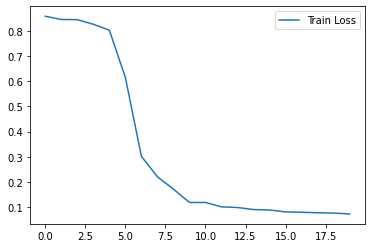

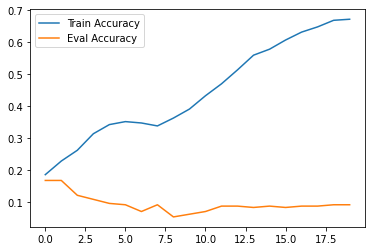

In [34]:
# 그래프로 loss 표기
#!pip install matplotlib
import matplotlib.pyplot as plt

plt.plot(list_train_loss, label='Train Loss')
#plt.plot(list_train_acc, label='Train Accuracy')
#plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()

plt.plot(list_train_acc, label='Train Accuracy')
plt.plot(list_validation_acc, label='Eval Accuracy')
plt.legend()
plt.show()